# Variational Autoencoder (VAE) from Scratch in PyTorch

This notebook demonstrates how to build a Variational Autoencoder (VAE) for the MNIST dataset using PyTorch. We will implement the core components by hand and explain the connection between the code and the underlying theory and equations.

## 1. Introduction to VAEs

Variational Autoencoders (VAEs) are generative models that learn a probability distribution over the input data. They consist of two main parts:

1.  **Encoder (Recognition Model):** $q_\phi(z|x)$. This network takes an input $x$ and outputs parameters (typically mean $\mu$ and log-variance $\log \sigma^2$) for a probability distribution in the latent space, $z$. This distribution approximates the true posterior $p(z|x)$.
2.  **Decoder (Generative Model):** $p_\theta(x|z)$. This network takes a sample $z$ from the latent distribution and reconstructs the input data $x$.

The goal of a VAE is to maximize the **Evidence Lower Bound (ELBO)**, which is a lower bound on the log-likelihood of the data $\log p(x)$:

$$ \mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) || p(z)) $$ 

Where:
- The first term, $\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]$, is the **reconstruction loss**. It encourages the decoder to accurately reconstruct the input $x$ from the latent representation $z$.
- The second term, $D_{KL}(q_\phi(z|x) || p(z))$, is the **Kullback-Leibler (KL) divergence** between the approximate posterior $q_\phi(z|x)$ learned by the encoder and a prior distribution $p(z)$ over the latent variables (usually a standard normal distribution, $\mathcal{N}(0, I)$). This term acts as a regularizer, forcing the latent space to be well-behaved (e.g., continuous and centered around the origin).

## 2. Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

/Users/samrouppe/opt/anaconda3/envs/3dcv-students/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Hyperparameters and Device Configuration

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 128
EPOCHS = 20 # Increase for better results, e.g., 20-50
LEARNING_RATE = 1e-3
INPUT_DIM = 28 * 28  # MNIST image dimensions (flattened)
HIDDEN_DIM = 400    # Dimension of hidden layers
LATENT_DIM = 20     # Dimension of the latent space z

# New parameters for number of hidden layers
NUM_ENCODER_LAYERS = 2 # e.g., input -> hidden -> hidden -> (mu, log_var)
NUM_DECODER_LAYERS = 2 # e.g., latent -> hidden -> hidden -> output

# For visualizing 2D latent space (optional, set LATENT_DIM=2 for this)
# LATENT_DIM = 2 

Using device: cpu


## 4. Data Loading (MNIST)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] tensor
    # transforms.Normalize((0.1307,), (0.3081,)) # Optional: Standard MNIST normalization
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:04<00:00, 2072106.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 174738.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:05<00:00, 309899.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1100042.08it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 5. VAE Model Definition

We'll define the VAE as a `nn.Module`.

### 5.1 Encoder Network: $q_\phi(z|x)$

The encoder network takes an input image $x$ and maps it to the parameters of a Gaussian distribution in the latent space. Specifically, it outputs a mean vector $\mu_z$ and a log-variance vector $\log(\sigma_z^2)$. We use log-variance for numerical stability and to ensure $\sigma_z^2$ is always positive.

Structure:
1.  Input layer (flattened image)
2.  One or more hidden layers (e.g., with ReLU activation)
3.  Two separate linear output layers: one for $\mu_z$ and one for $\log(\sigma_z^2)$.

The output of the encoder defines $q_\phi(z|x) = \mathcal{N}(z; \mu_z, \text{diag}(\sigma_z^2))$.

### 5.2 Reparameterization Trick

To train the VAE using backpropagation, we need to sample $z$ from $q_\phi(z|x)$. However, the sampling operation itself is stochastic and non-differentiable. The **reparameterization trick** allows us to re-express the sampling process in a way that makes it differentiable.

Instead of sampling $z \sim \mathcal{N}(\mu_z, \sigma_z^2)$, we sample a noise variable $\epsilon \sim \mathcal{N}(0, I)$ (a standard normal distribution, which is parameter-free) and then compute $z$ as:

$$ z = \mu_z + \sigma_z \odot \epsilon $$

Here, $\odot$ denotes element-wise multiplication. Since $\sigma_z = \exp(0.5 \cdot \log(\sigma_z^2))$, the equation becomes:

$$ z = \mu_z + \exp(0.5 \cdot \log(\sigma_z^2)) \odot \epsilon $$

Now, the stochasticity comes from $\epsilon$, which is an input to this computation. The transformation from $\epsilon$, $\mu_z$, and $\log(\sigma_z^2)$ to $z$ is deterministic, allowing gradients to flow back through $\mu_z$ and $\log(\sigma_z^2)$ to the encoder parameters $\phi$.

### 5.3 Decoder Network: $p_\theta(x|z)$

The decoder network takes a latent sample $z$ and maps it back to the data space, aiming to reconstruct the original input $x$. Its output, $\hat{x}$, represents the parameters of the distribution $p_\theta(x|z)$. For MNIST, where pixel values are typically between 0 and 1, we often model $p_\theta(x|z)$ as a Bernoulli distribution for each pixel. The decoder outputs the probability parameter for each pixel, often using a sigmoid activation function.

Structure:
1.  Input layer (latent vector $z$)
2.  One or more hidden layers (e.g., with ReLU activation)
3.  Output layer (reconstructed image, with sigmoid activation for pixel values in [0,1]).

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim,
                 num_encoder_layers=1, num_decoder_layers=1):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # === Encoder Part ===
        # q_phi(z|x)
        encoder_modules = []
        # First layer: input_dim -> hidden_dim
        encoder_modules.append(nn.Linear(input_dim, hidden_dim))
        encoder_modules.append(nn.ReLU())

        # Additional hidden layers: hidden_dim -> hidden_dim
        # num_encoder_layers specifies the total number of layers that use hidden_dim
        # before branching to mu and log_var.
        # So, if num_encoder_layers is 1, only the above layer is created.
        # If num_encoder_layers is > 1, we add (num_encoder_layers - 1) more.
        for _ in range(num_encoder_layers - 1):
            encoder_modules.append(nn.Linear(hidden_dim, hidden_dim))
            encoder_modules.append(nn.ReLU())

        # This sequential block contains all layers up to the one that outputs `hidden_dim` features
        self.encoder_shared_layers = nn.Sequential(*encoder_modules)

        # From the final shared hidden representation, we get mu and log_var
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # To output mu
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim) # To output log_var

        # === Decoder Part ===
        # p_theta(x|z)
        decoder_modules = []
        # First layer: latent_dim -> hidden_dim
        decoder_modules.append(nn.Linear(latent_dim, hidden_dim))
        decoder_modules.append(nn.ReLU())

        # Additional hidden layers: hidden_dim -> hidden_dim
        # num_decoder_layers specifies the total number of layers that use hidden_dim
        # before the final output layer.
        for _ in range(num_decoder_layers - 1):
            decoder_modules.append(nn.Linear(hidden_dim, hidden_dim))
            decoder_modules.append(nn.ReLU())

        # This sequential block contains all layers up to the one that outputs `hidden_dim` features
        self. decoder_shared_layers = nn.Sequential(*decoder_modules)

        # From the final shared hidden representation, we reconstruct x
        self.fc_output = nn.Linear(hidden_dim, input_dim) # To output reconstructed x

    def encode(self, x):
        """Maps input x to mu and log_var for the latent space distribution q_phi(z|x)."""
        # Pass through the shared encoder layers
        h_encoder = self.encoder_shared_layers(x)
        # Get mu and log_var from the output of the shared layers
        mu = self.fc_mu(h_encoder)
        log_var = self.fc_log_var(h_encoder)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Maps latent vector z back to the reconstructed data space x_hat."""
        # Pass through the shared decoder layers
        h_decoder = self.decoder_shared_layers(z)
        # Get reconstructed x from the output of the shared layers
        recon_x = torch.sigmoid(self.fc_output(h_decoder))
        return recon_x

    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        mu, log_var = self.encode(x_flat)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var

# Instantiate the model with configurable number of layers
model = VAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            num_decoder_layers=NUM_DECODER_LAYERS).to(DEVICE)

## 6. Loss Function (ELBO)

As mentioned, we want to maximize the ELBO:
$$ \mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) || p(z)) $$

In practice, we minimize the negative ELBO:
$$ -\mathcal{L} = -\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] + D_{KL}(q_\phi(z|x) || p(z)) $$

This is often written as:
$$ \text{Loss} = \text{Reconstruction Loss} + \text{KL Divergence} $$

1.  **Reconstruction Loss**: For Bernoulli distributed outputs (pixel values in [0,1] from sigmoid), the term $-\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]$ becomes the **Binary Cross-Entropy (BCE)** between the original input $x$ and the reconstructed output $\hat{x}$ (which are the Bernoulli parameters from the decoder).
    $$ \text{BCE}(x, \hat{x}) = - \sum_{i=1}^{\text{dim}(x)} [x_i \log(\hat{x}_i) + (1-x_i) \log(1-\hat{x}_i)] $$
    PyTorch's `F.binary_cross_entropy` with `reduction='sum'` calculates this.

2.  **KL Divergence**: The KL divergence between $q_\phi(z|x) = \mathcal{N}(\mu_z, \text{diag}(\sigma_z^2))$ and the prior $p(z) = \mathcal{N}(0, I)$ has an analytical solution:
    $$ D_{KL}(\mathcal{N}(\mu_z, \sigma_z^2) || \mathcal{N}(0, I)) = -0.5 \sum_{j=1}^{\text{LATENT DIM}} (1 + \log(\sigma_{z,j}^2) - \mu_{z,j}^2 - \sigma_{z,j}^2) $$

    Where $j$ indexes the dimensions of the latent space. Remember $\sigma_{z,j}^2 = \exp(\log(\sigma_{z,j}^2))$.

In [5]:
def loss_function(recon_x, x, mu, log_var):
    """
    Computes the VAE loss, which is the sum of reconstruction loss and KL divergence.
    recon_x: a tensor of shape (batch_size, input_dim) - reconstructed input
    x: a tensor of shape (batch_size, input_dim) - original input
    mu: a tensor of shape (batch_size, latent_dim) - latent mean
    log_var: a tensor of shape (batch_size, latent_dim) - latent log variance
    """
    # 1. Reconstruction Loss (Binary Cross Entropy)
    # We use F.binary_cross_entropy. It expects recon_x (probabilities) and x (binary targets).
    # The sum over dimensions is important for proper weighting against KLD.
    # x.view(-1, INPUT_DIM) ensures x is flattened just like recon_x
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, INPUT_DIM), reduction='sum')
    
    # 2. KL Divergence
    # D_KL(q_phi(z|x) || p(z)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma^2 = exp(log_var)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # Total loss
    return BCE + KLD

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 7. Training Loop

In [6]:
def train(epoch):
    model.train() # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader): # We don't need labels for VAE
        data = data.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, log_var = model(data)
        
        # Calculate loss
        loss = loss_function(recon_batch, data, mu, log_var)
        
        # Backward pass and optimize
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ' 
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}')
    return avg_train_loss

def test(epoch):
    model.eval() # Set model to evaluation mode
    test_loss = 0
    with torch.no_grad(): # No gradients needed for evaluation
        for i, (data, _) in enumerate(test_loader):
            data = data.to(DEVICE)
            recon_batch, mu, log_var = model(data)
            test_loss += loss_function(recon_batch, data, mu, log_var).item()
            
            # For the first batch in the first epoch, save original and reconstructed images for visualization
            if i == 0 and epoch % 5 == 0: # Show every 5 epochs
                n = min(data.size(0), 8) # Display up to 8 images
                comparison = torch.cat([data[:n].view(-1, 1, 28, 28), # Original
                                      recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]]) # Reconstructed
                # Convert to numpy for plotting
                comparison_np = comparison.cpu().numpy().squeeze()
                
                fig, axes = plt.subplots(2, n, figsize=(n*1.5, 3))
                for img_idx in range(n):
                    axes[0, img_idx].imshow(comparison_np[img_idx], cmap='gray')
                    axes[0, img_idx].set_title("Original")
                    axes[0, img_idx].axis('off')
                    axes[1, img_idx].imshow(comparison_np[n+img_idx], cmap='gray')
                    axes[1, img_idx].set_title("Recon")
                    axes[1, img_idx].axis('off')
                plt.suptitle(f"Epoch {epoch} Reconstructions", fontsize=16)
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()

    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f'====> Test set loss: {avg_test_loss:.4f}')
    return avg_test_loss

# Start training
train_losses = []
test_losses = []
for epoch in range(1, EPOCHS + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.718140
Train Epoch: 1 [12800/60000 (21%)]	Loss: 190.915817
Train Epoch: 1 [25600/60000 (43%)]	Loss: 153.117828
Train Epoch: 1 [38400/60000 (64%)]	Loss: 137.831146
Train Epoch: 1 [51200/60000 (85%)]	Loss: 123.412399
====> Epoch: 1 Average loss: 165.6819
====> Test set loss: 128.3443
Train Epoch: 2 [0/60000 (0%)]	Loss: 131.533340
Train Epoch: 2 [12800/60000 (21%)]	Loss: 119.840439
Train Epoch: 2 [25600/60000 (43%)]	Loss: 123.036461
Train Epoch: 2 [38400/60000 (64%)]	Loss: 123.405029
Train Epoch: 2 [51200/60000 (85%)]	Loss: 112.811142
====> Epoch: 2 Average loss: 121.7666
====> Test set loss: 116.1347
Train Epoch: 3 [0/60000 (0%)]	Loss: 118.171165
Train Epoch: 3 [12800/60000 (21%)]	Loss: 113.517349


KeyboardInterrupt: 

## 8. Visualizing Results

### 8.1 Loss Curves

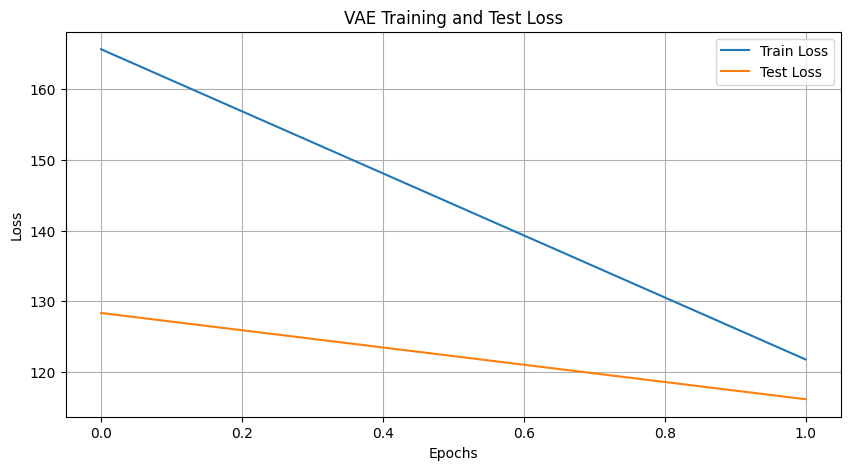

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('VAE Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 8.2 Generating New Samples

To generate new samples, we sample $z$ from the prior distribution $p(z) = \mathcal{N}(0, I)$ and pass it through the decoder $p_\theta(x|z)$.

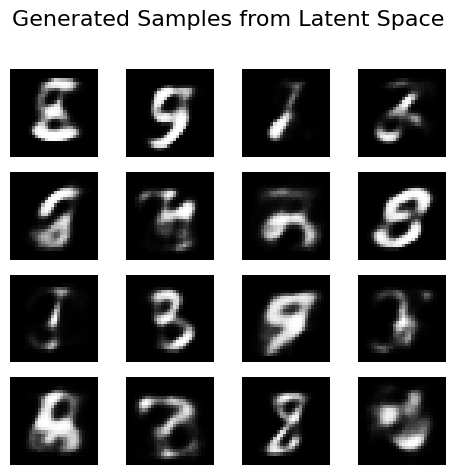

In [8]:
def generate_samples(num_samples=64):
    model.eval()
    with torch.no_grad():
        # Sample z from the prior N(0, I)
        z_sample = torch.randn(num_samples, LATENT_DIM).to(DEVICE)
        # Decode z to generate new images
        generated_images = model.decode(z_sample).cpu()
        
    # Reshape and plot
    generated_images = generated_images.view(num_samples, 1, 28, 28)
    
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*1.2, grid_size*1.2))
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(generated_images[i].squeeze(), cmap='gray')
            ax.axis('off')
    plt.suptitle('Generated Samples from Latent Space', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

generate_samples(num_samples=16) # Generate 16 samples (4x4 grid)

### 8.3 Visualizing Latent Space (if LATENT_DIM = 2)

If `LATENT_DIM` was set to 2, we can visualize how the MNIST digits are distributed in this 2D latent space.

In [9]:
def plot_latent_space():
    if LATENT_DIM != 2:
        print("Latent space visualization is only for LATENT_DIM=2.")
        print(f"Current LATENT_DIM is {LATENT_DIM}.")
        return

    model.eval()
    latent_vectors = []
    labels_list = []
    with torch.no_grad():
        for data, labels in test_loader: # Use test_loader for a manageable number of points
            data = data.to(DEVICE)
            mu, _ = model.encode(data.view(-1, INPUT_DIM))
            latent_vectors.append(mu.cpu())
            labels_list.append(labels.cpu())
    
    latent_vectors = torch.cat(latent_vectors).numpy()
    labels_list = torch.cat(labels_list).numpy()
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels_list, cmap='tab10', alpha=0.7, s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('MNIST Latent Space ($\mu$ vectors)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.show()

plot_latent_space()

Latent space visualization is only for LATENT_DIM=2.
Current LATENT_DIM is 20.


## 9. Conclusion

This notebook provided a step-by-step implementation of a Variational Autoencoder in PyTorch.

Key takeaways:
- **Encoder $q_\phi(z|x)$**: Maps input $x$ to parameters $(\mu, \log \sigma^2)$ of a Gaussian latent distribution.
- **Reparameterization Trick**: $z = \mu + \sigma \odot \epsilon$, enabling backpropagation through the sampling process.
- **Decoder $p_\theta(x|z)$**: Maps latent sample $z$ back to reconstruct $x$.
- **Loss Function (ELBO)**: Combines reconstruction loss (e.g., BCE) and KL divergence to regularize the latent space.

VAEs are powerful generative models capable of learning complex data distributions and generating new, realistic samples.